In [ ]:
import argparse
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from datasets_prep.dataset import create_dataset
#from diffusion import sample_from_model, sample_posterior, \
#    q_sample_pairs, get_time_schedule, \
#    Posterior_Coefficie
#nts, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

In [ ]:
def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward()

device = "cuda:0"

In [ ]:
from ldm.util import instantiate_from_config
config_path = "./autoencoder/config/cifar10_16x16x4.yaml"
ckpt_path = "./autoencoder/weight/16x16x4_551.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder.load_state_dict(checkpoint['state_dict'])
AutoEncoder.eval()
AutoEncoder.to(device)

In [ ]:
from ldm.util import instantiate_from_config
config_path = "./autoencoder/config/vq-f8.yaml"
ckpt_path = "./autoencoder/weight/vq-f8.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder.load_state_dict(checkpoint['state_dict'])
AutoEncoder.eval()
AutoEncoder.to(device)

In [83]:
import os

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import CIFAR10, STL10

from datasets_prep.coco import CustomCocoCaptions
size = 256
datadir ="./data/coco"
train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.transforms.CenterCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CustomCocoCaptions(
    name="train2017",
    root=os.path.join(datadir, "train2017"),
    annFile=os.path.join(
    datadir, 'annotations', 'captions_train2017.json'),
    transform=train_transform)

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=2,
                                          pin_memory=True,
                                          #sampler=train_sampler,
                                          drop_last=True
                                         )

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!


In [84]:
from PIL import Image

In [85]:
tmp = iter(data_loader)
x, y = next(tmp)

In [86]:
device = "cuda"
scale_factor = 1.0
x0 = x.to(device, non_blocking=True)
with torch.no_grad():
    posterior = AutoEncoder.encode(x0)
    real_data = posterior.detach()
#print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
real_data = real_data / scale_factor #300.0  # [-1, 1]

In [87]:
posterior.shape

torch.Size([1, 4, 64, 64])

['A bunch of trays that have different food.']


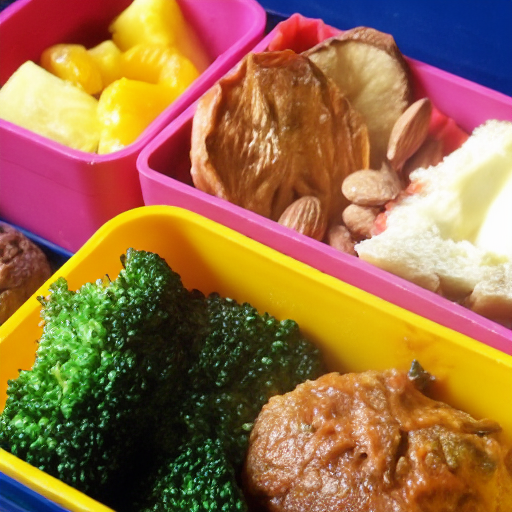

In [88]:
real_data *= scale_factor #300
with torch.no_grad():
    real_data = AutoEncoder.decode(real_data)

real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 

torchvision.utils.save_image(
    real_data, os.path.join("./", 'real_data.png'))
imgPIL = Image.open("./real_data.png")  # 画像読み込み

print(y)
imgPIL.show()  # 画像表示

In [ ]:
dataset = CIFAR10("./data/cifar-10", train=True, transform=transforms.Compose([
            transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1,           
                                         )

In [ ]:
!bash lab_run.sh cifar10 train 1